<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras_tuner as kt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

### Loading Data

In [3]:
# Load preprocessed data
df = pd.read_csv('preprocessed_bitcoin_data.csv', index_col='Date', parse_dates=True)

# Display the first few rows of the data
df.head()

,Close,High,Low,Open,Volume,Close_diff
Date,,,,,,
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,-32.894012
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,-29.644012
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,14.108002
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,-10.082977
2014-09-22,402.152008,406.915985,397.130005,399.100006,24127600,3.330994


In [4]:
# Select only 'Close' column for prediction
data = df[['Close']].values  # Convert to NumPy array

In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

In [6]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [7]:
seq_length = 60  # Use last 60 days to predict next day
X, y = create_sequences(data_scaled, seq_length)

In [8]:
# Split into training and testing sets
split = int(0.8 * len(X))   # 20% for validation
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [10]:
X_train.shape

(2985, 60, 1)

In [18]:
# Define the LSTM model
model = Sequential()

# First LSTM layer with BatchNormalization
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # default activation (tanh and sigmoid)
model.add(BatchNormalization())  # Batch Normalization layer
model.add(Dropout(0.3))

# Second LSTM layer with BatchNormalization
model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Third LSTM layer
model.add(LSTM(32))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='linear'))  # 'linear' for regression

In [19]:
# Print model summary to check the architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 60, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 60, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 60, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,313 (505.13 KB)

 Trainable params: 128,865 (503.38 KB)

 Non-trainable params: 448 (1.75 KB)

In [24]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'accuracy'])

In [33]:
# Train the model with early stopping and validation data

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 2.5876e-04 - loss: 0.0018 - mae: 0.0309 - val_accuracy: 0.0013 - val_loss: 0.0152 - val_mae: 0.0801
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 1.1914e-04 - loss: 0.0015 - mae: 0.0309 - val_accuracy: 0.0013 - val_loss: 0.0108 - val_mae: 0.0501
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 9.9929e-05 - loss: 0.0016 - mae: 0.0295 - val_accuracy: 0.0013 - val_loss: 0.0150 - val_mae: 0.0806
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 5.3997e-04 - loss: 0.0013 - mae: 0.0272 - val_accuracy: 0.0013 - val_loss: 0.0083 - val_mae: 0.0523
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 2.5131e-05 - loss: 0.0013 - mae: 0.0274 - val_accuracy: 0.0013 - val_loss: 0.0098 - val_mae: 0.0649
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.7780e-05 - loss: 0.0013 - mae: 0.0274 - val_accuracy: 0.0013 - val_loss: 0.0104 - val_mae: 0.0630
Epoch 7/50
94/94 ━━━━━

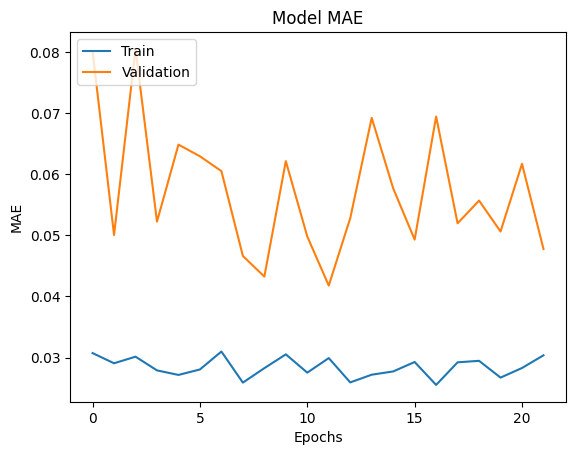

In [34]:
# Plot training & validation MAE
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
# Convert y_test back to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

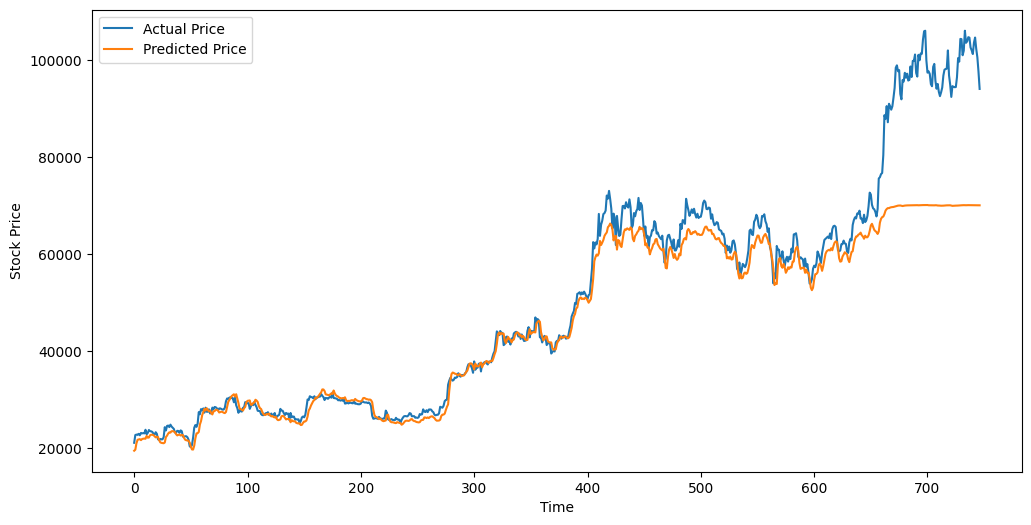

In [36]:
# Compare predicted vs actual values
plt.figure(figsize=(12,6))
plt.plot(y_test_original, label="Actual Price")
plt.plot(predictions, label="Predicted Price")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

## Hyperparameter Tuning

In [39]:
# Define the hypermodel for tuning
def build_model(hp):
    model = Sequential()

    # Tuning the number of LSTM units and layers
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                   return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32),
                   return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(LSTM(units=hp.Int('units_3', min_value=32, max_value=256, step=32)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='linear'))